## 統計學習與深度學習 HW4
##### B08705038 資管四 郭子麟

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Multilayer Perceptrons for Regression
本次作業的主角是 Multilayer perceptrons (MLP)。我們將以MLP建構迴歸模型，探討各項相關議題。


#### Dataset: Million Songs Dataset
本次作業將使用"Million Songs Dataset"作為訓練與測試資料。請使用`pickle.load()`載入*msd_full.pickle*。這個資料集已經切割好了訓練與測試資料，並存放在一個Dictionary的結構。這個Dictionary有四個元素，x_train, y_train, x_test, y_test，分別對應到訓練特徵、訓練標記(Label)、測試特徵、測試標記。 標記變數 (label variable; i.e., $y$) 是歌曲發行年度。特徵為歌曲的聲音特性。迴歸任務為預測歌曲年分。

#### Prediction Performance and Loss Function
模型訓練應主要使用Sum of Squared Error (SSE)建構Loss Function，另外我們也會練習使用其他種類的Loss Function。為了讓圖表易於理解，不論Loss Function為何，報告預測能力應使用Root Mean Squared Error (RMSE)。使用SSE或RMSE建構Loss Function在本質上沒有差別。但SSE計算成本稍低，而RMSE較有直觀意義。


#### Subtraining, Validation, and Test Datasets
*msd_full.pickle* 檔案中的訓練資料已經隨機排序過。你應該使用訓練資料最後10%的資料做為Validation Set。其餘的前90%做為Subtraining Set。使用Subtraining Set來訓練資料，並以Validation Set作為參數調教與Early Stopping的依據。Test RMSE應使用測試資料計算得之。

所有特徵應該標準化(均數為零，變異數為一)。標準化應該以訓練資料(注意不是Test Set or Subtraining Set)的統計量為之。標記變數(i.e., $y$)應將均數平移至0 (依照訓練資料的統計量)。標記變數的變異數不要調整。


#### Minibatch, Epoch, and Early Stopping
如果沒有特別說明，模型訓練時應以大小為1,000個資料點的Minibatch為之。模型使用一個Minibatch的資料更新參數之後稱為經歷了一個Batch。當所有Subtraining資料已經用來更新過模型參數，稱為經過了一個Epoch。

模型訓練應使用Early Stopping決定最佳的模型。模型訓練時每100個Batch計算一次Training and Validation RMSE。如果Validation為歷史最低，則記下當下的模型參數與當時已進行的Batch數量，稱為best_step_count。如由best_step_count起算已經經過了5,000個Batch而沒有更好的Validation RMSE，則停止模型訓練，並以best_step_count時的模型參數做為最後的模型訓練結果。如果模型訓練最多執行100個epoch。如果模型已經執行了100個epoch而沒有Early Stop，則應使用歷史最佳的Validation RMSE所對應到的模型參數計算Test RMSE。


#### Implementation Restriction
使用Pytorch建構MLP模型。Ordinary Least Square (OLS)模型訓練沒有限制使用何種套件。

### 資料載入
使用下面的程式碼載入資料:

In [3]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### 回答下面問題

#### Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [6]:
# use ols model to fit the data and list first 5 features' weights and the RMSE. There should be no regularization.
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

ols = linear_model.LinearRegression()
ols.fit(X_subtrain, Y_subtrain)
Y_pred = ols.predict(X_valid)
print("RMSE = ", np.sqrt(mean_squared_error(Y_valid, Y_pred)))
print("First 5 features' weights = ", ols.coef_[0:5])

RMSE =  9.519575
First 5 features' weights =  [ 5.2934227  -2.8868341  -1.5276396   0.06306481 -0.33957952]


#### Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。


##### Construct Dataset and DataLoader

##### Construct a MLP Model Class

In [82]:
import copy
import matplotlib.pyplot as plt
import torch
from torch.utils import data
import numpy as np

class L2L1Loss(torch.nn.Module):
    def __init__(self, loss_z):
        super(L2L1Loss, self).__init__()
        self.loss_z = loss_z
    def forward(self, Y_pred, Y):
        return self.loss_z * torch.nn.MSELoss(reduction='sum')(Y_pred, Y) + (1 - self.loss_z) * torch.nn.L1Loss(reduction='sum')(Y_pred, Y)

class CustomizedL2Loss(torch.nn.Module):
    def __init__(self, loss_z):
        super(CustomizedL2Loss, self).__init__()
        self.loss_z = loss_z
    def forward(self, Y_pred, Y):
        return self.loss_z * torch.nn.MSELoss(reduction='sum')(Y_pred, Y) + (1 - self.loss_z) * abs(torch.nn.L1Loss(reduction='sum')(Y_pred, Y))

class MSDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

class MyMLP():
    def __init__(self, X_subtrain, Y_subtrain, X_valid, Y_valid, H = 45, lr = 0.00001, optimizer_type = 0, loss_type = 0, wd = 0, mom = 0, use_dropout = False, dropout_rate = 0.5, loss_z = 0.5):
        """
        #### Parameters
        - X_subtrain: training data
        - Y_subtrain: training label
        - X_valid: validation data
        - Y_valid: validation label
        - H: the number of hidden units for each layer. Default is 45.
        - lr: learning rate. Default: 0.00001
        - wd: weight decay. Default: 0
        - mom: momentum. Default: 0
        - loss_type: the type of loss function. 0: SSE, 1: L2 + L1, 2: L2 customized. Default: 0
        - optimizer_type: the type of optimizer. 0: SGD, 1: Adam. Default: 0
        - use_dropout: whether to use dropout. Default: False
        - dropout_rate: the rate of dropout. 0.5 by default
        - loss_z: the parameter for L2 + L1 loss function. 0.5 by default
        """
        self.train_dataset = MSDataset(X_subtrain, Y_subtrain)
        self.valid_dataset = MSDataset(X_valid, Y_valid)
        self.train_loader = data.DataLoader(self.train_dataset, batch_size=1000, shuffle=True)
        self.valid_loader = data.DataLoader(self.valid_dataset, batch_size=1000, shuffle=False)
        self.H = H
        self.lr = lr
        self.wd = wd
        self.mom = mom
        self.loss_type = loss_type
        self.optimizer_type = optimizer_type
        self.use_dropout = use_dropout
        self.dropout_rate = dropout_rate
        self.loss_z = loss_z
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.__get_model_sequential()
        self.loss_function = self.__get_loss_function()
        self.optimizer = self.__get_optimizer()

    def __get_model_sequential(self):
        if self.use_dropout:
            model = torch.nn.Sequential(
                torch.nn.Linear(90, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = self.dropout_rate),
                torch.nn.Linear(self.H, 1)
            )
        else:
            model = torch.nn.Sequential(
                torch.nn.Linear(90, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, self.H),
                torch.nn.ReLU(),
                torch.nn.Linear(self.H, 1)
            )
        model.float().to(self.device)
        return model
    def __get_loss_function(self):
        if self.loss_type == 0: # SSE
            loss_function = torch.nn.MSELoss(reduction='sum')
        elif self.loss_type == 1: # L2 + L1
            loss_function = L2L1Loss(self.loss_z)
        else: # L2 customized
            loss_function = CustomizedL2Loss(self.loss_z)
        return loss_function
    def fit(self, max_epoch = 100, verbose = True, patience_batch_num = 5000, model_path = 'model.ckpt'):
        """
        For every 100 batches, print the training loss and validation loss.\n
        It will return two lists: training loss and validation loss.
        #### Parameters
        - max_epoch: the maximum number of epochs. Default: 100
        - verbose: whether to print the training information. Default: True
        - patience_batch_num: the number of batches to wait before early stopping. Default: 5000
        """
        cur_step = 0
        cur_epoch = 0
        patience = 0
        best_valid_loss = np.inf
        train_loss_list = []
        valid_loss_list = []
        while cur_epoch < max_epoch:
            for _, (batch_X, batch_Y) in enumerate(self.train_loader):
                self.model.train() # switch to train mode
                self.optimizer.zero_grad()
                batch_X = batch_X.to(self.device)
                batch_Y = batch_Y.reshape((-1, 1)).to(self.device)
                batch_Y_pred = self.model(batch_X)
                loss = self.loss_function(batch_Y_pred, batch_Y)
                loss.backward()
                self.optimizer.step()
                cur_step += 1
                if cur_step % 100 == 0:
                    # train loss should use RMSE for the training set
                    train_loss = 0
                    train_size = 0
                    self.model.eval()
                    for _, (batch_X, batch_Y) in enumerate(self.train_loader):
                        batch_X = batch_X.to(self.device)
                        batch_Y = batch_Y.reshape((-1, 1)).to(self.device)
                        batch_Y_pred = self.model(batch_X)
                        train_loss += torch.nn.MSELoss(reduction='sum')(batch_Y_pred, batch_Y).item()
                        train_size += batch_X.shape[0]
                    rmse_train_loss = np.sqrt(train_loss / train_size)
                    train_loss_list.append(rmse_train_loss)
                    valid_loss = 0
                    valid_rmse_loss = 0
                    valid_size = 0
                    for _, (batch_X, batch_Y) in enumerate(self.valid_loader):
                        valid_size += batch_X.shape[0]
                        batch_X = batch_X.to(self.device)
                        batch_Y = batch_Y.reshape((-1, 1)).to(self.device)
                        batch_Y_pred = self.model(batch_X)
                        loss = self.loss_function(batch_Y_pred, batch_Y)
                        valid_loss += loss.item()
                        valid_rmse_loss += torch.nn.MSELoss(reduction='sum')(batch_Y_pred, batch_Y).item()
                    valid_rmse_loss = np.sqrt(valid_rmse_loss / valid_size)
                    valid_loss_list.append(valid_rmse_loss)
                    if valid_loss < best_valid_loss:
                        best_valid_loss = valid_loss
                        best_model = copy.deepcopy(self.model)
                        patience = 0
                    else:
                        patience += 1
                    if verbose:
                        print("Epoch: {}, Step: {}, Train Loss: {}, Valid Loss: {}".format(cur_epoch, cur_step, train_loss_list[-1], valid_loss_list[-1]))
                    if patience >= patience_batch_num:
                        self.model = best_model
                        print("Early stopping at epoch {}, step {}".format(cur_epoch, cur_step))
                        torch.save(self.model, model_path)
                        return train_loss_list, valid_loss_list
            cur_epoch += 1
        self.model = best_model
        torch.save(self.model, model_path)
        return train_loss_list, valid_loss_list
    def __get_optimizer(self):
        if self.optimizer_type == 0: # SGD
            optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, weight_decay=self.wd, momentum=self.mom)
        else: # Adam
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        return optimizer

In [59]:
def calculate_test_rmse(model, X_test, Y_test):
    test_dataset = MSDataset(X_test, Y_test)
    test_loader = data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loss = 0
    test_size = 0
    for _, (batch_X, batch_Y) in enumerate(test_loader):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.reshape((-1, 1)).to(device)
        batch_Y_pred = model(batch_X)
        test_loss += torch.nn.MSELoss(reduction='sum')(batch_Y_pred, batch_Y).item()
        test_size += batch_X.shape[0]
    test_rmse_loss = np.sqrt(test_loss / test_size)
    return test_rmse_loss

##### Construct a MLP Model and Train

In [53]:
q2_mlp = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=45,
    lr=0.00001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=0,
    use_dropout=False
)
train_loss_list, valid_loss_list = q2_mlp.fit(max_epoch=100, verbose=True, patience_batch_num=5000, model_path='q2_mlp.ckpt')

Epoch: 0, Step: 100, Train Loss: 10.634806085843973, Valid Loss: 10.609656744566204
Epoch: 0, Step: 200, Train Loss: 9.090645590777221, Valid Loss: 9.0104417124174
Epoch: 0, Step: 300, Train Loss: 9.008724315673865, Valid Loss: 8.964793240422235
Epoch: 0, Step: 400, Train Loss: 8.85230780792544, Valid Loss: 8.804481024175608


In [62]:
best_model_q2 = torch.load('q2_mlp.ckpt')
test_rmse_loss = calculate_test_rmse(best_model_q2, X_test, Y_test)
print("Test RMSE Loss: {}".format(test_rmse_loss))

Test RMSE Loss: 8.934501721928912


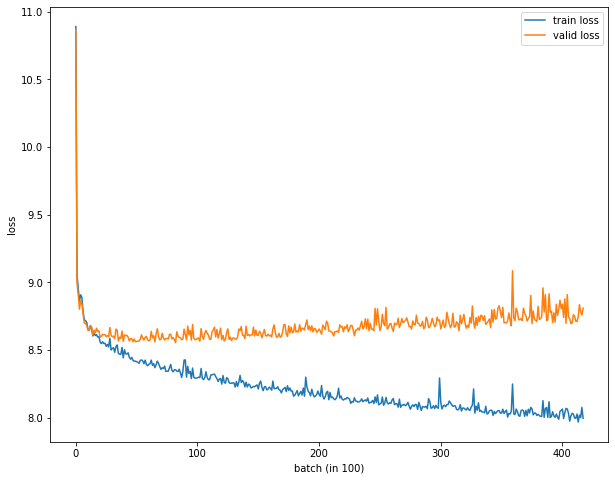

In [39]:
# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
def draw_loss(train_loss_list, valid_loss_list):
        """
        Draw the training loss and validation loss.
        """
        plt.plot(train_loss_list, label = "train loss")
        plt.plot(valid_loss_list, label = "valid loss")
        plt.xlabel("batch (in 100)")
        plt.ylabel("loss")
        plt.legend()
        plt.show()
draw_loss(train_loss_list, valid_loss_list)

從上圖可以看出，在訓練過程中，Training RMSE 與 Validation RMSE 在前幾千個 Batch 都在下降。  
但後來 Validation RMSE 開始上升，而 Training RMSE 仍在下降，這代表模型開始 Overfitting。

#### Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。


In [63]:
mlp_90 = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=90,
    lr=0.00001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=0,
    use_dropout=False
)
train_loss_list, valid_loss_list = mlp_90.fit(
    max_epoch=100, 
    verbose=True, 
    patience_batch_num=5000, 
    model_path='q3_mlp_90.ckpt'
)

Epoch: 0, Step: 100, Train Loss: 9.942243679162095, Valid Loss: 9.898914593406602
Epoch: 0, Step: 200, Train Loss: 9.07490035989813, Valid Loss: 9.013738549663888
Epoch: 0, Step: 300, Train Loss: 9.030378943292307, Valid Loss: 9.000228638316583
Epoch: 0, Step: 400, Train Loss: 8.851100078801414, Valid Loss: 8.815910807268018


In [64]:
q3_mlp_90_best_model = torch.load('q3_mlp_90.ckpt')
test_rmse_loss = calculate_test_rmse(q3_mlp_90_best_model, X_test, Y_test)
print(f"Test RMSE Loss for 90 hidden units: {test_rmse_loss}")

Test RMSE Loss for 90 hidden units: 8.965207331652502


In [65]:
mlp_180 = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=180,
    lr=0.00001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=0,
    use_dropout=False
)
train_loss_list, valid_loss_list = mlp_180.fit(
    max_epoch=100, 
    verbose=True, 
    patience_batch_num=5000, 
    model_path='q3_mlp_180.ckpt'
)

Epoch: 0, Step: 100, Train Loss: 9.347551184891104, Valid Loss: 9.289103468933975
Epoch: 0, Step: 200, Train Loss: 9.120534683241981, Valid Loss: 9.06655679164779
Epoch: 0, Step: 300, Train Loss: 8.871531430202332, Valid Loss: 8.832074798568065
Epoch: 0, Step: 400, Train Loss: 8.795377837172458, Valid Loss: 8.763463263068273


In [66]:
q3_mlp_180_best_model = torch.load('q3_mlp_180.ckpt')
test_rmse_loss = calculate_test_rmse(q3_mlp_180_best_model, X_test, Y_test)
print(f"Test RMSE Loss for 90 hidden units: {test_rmse_loss}")

Test RMSE Loss for 90 hidden units: 8.918703611390761


##### Discussion on Test RMSE with different H (H = 45, 90, 180)
由上可知，不同的 H 其所對應的 Test RMSE 如下：
* H = 45: 8.934501721928912
* H = 90: 8.965207331652502
* H = 180: 8.918703611390761

TODO: 討論 H = 45, 90, 180 的 Test RMSE

#### Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?


In [67]:
h_list = [45, 90, 180]
wd_list = [0.1, 0.2, 0.4]
rmse_dict = []
for h in h_list:
    for wd in wd_list:
        print(f"Start training for h = {h}, wd = {wd}")
        mlp = MyMLP(
            X_subtrain=X_subtrain,
            Y_subtrain=Y_subtrain,
            X_valid=X_valid,
            Y_valid=Y_valid,
            H=h,
            lr=0.00001,
            wd=wd,
            mom=0,
            loss_type=0,
            optimizer_type=0,
            use_dropout=False
        )
        mlp.fit(
            max_epoch=100,
            verbose=True,
            patience_batch_num=5000,
            model_path=f'q4_mlp_h_{h}_wd_{wd}.ckpt'
        )
        best_model = torch.load(f'q4_mlp_h_{h}_wd_{wd}.ckpt')
        test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
        rmse_record = {
            'h': h,
            'wd': wd,
            'test_rmse_loss': test_rmse_loss
        }
        rmse_dict.append(rmse_record)
        print(f"Test RMSE Loss for h = {h}, wd = {wd}: {test_rmse_loss}")

Start training for h = 45, wd = 0.1
Epoch: 0, Step: 100, Train Loss: 10.930431449407061, Valid Loss: 10.9099851735056
Epoch: 0, Step: 200, Train Loss: 9.141422272972408, Valid Loss: 9.08553041443884
Epoch: 0, Step: 300, Train Loss: 9.004023512712688, Valid Loss: 8.948015010682507
Epoch: 0, Step: 400, Train Loss: 8.922735264565725, Valid Loss: 8.884536967721909
Test RMSE Loss for h = 45, wd = 0.1: 9.00447210292681
Start training for h = 45, wd = 0.2
Epoch: 0, Step: 100, Train Loss: 10.920831943987416, Valid Loss: 10.900190666284129
Epoch: 0, Step: 200, Train Loss: 9.12202265601901, Valid Loss: 9.063663096143207
Epoch: 0, Step: 300, Train Loss: 8.950089641942933, Valid Loss: 8.90282652941915
Epoch: 0, Step: 400, Train Loss: 8.859644852449481, Valid Loss: 8.81328917364331
Test RMSE Loss for h = 45, wd = 0.2: 8.975167864269817
Start training for h = 45, wd = 0.4
Epoch: 0, Step: 100, Train Loss: 10.208052003718674, Valid Loss: 10.159294820764018
Epoch: 0, Step: 200, Train Loss: 9.1035269155

In [68]:
# display the result in a table
import pandas as pd
pd.DataFrame(rmse_dict)

,h,wd,test_rmse_loss
0,45,0.1,9.004472
1,45,0.2,8.975168
2,45,0.4,8.974453
3,90,0.1,8.982456
4,90,0.2,8.976532
5,90,0.4,8.967433
6,180,0.1,8.906946
7,180,0.2,8.906602
8,180,0.4,8.992600


In [70]:
# print the best h and wd with lowest test rmse loss
best_rmse_record = min(rmse_dict, key=lambda x: x['test_rmse_loss'])
print(f"Best h: {best_rmse_record['h']}")
print(f"Best wd: {best_rmse_record['wd']}")
print(f"Best test rmse loss: {best_rmse_record['test_rmse_loss']}")

Best h: 180
Best wd: 0.2
Best test rmse loss: 8.906601526493883


TODO: 由上可知，我們應該選擇 H = 180, weight decay = 0.2 的組合，因為其 Test RMSE 最小。

#### Q5 MLP with Dropout (15%)
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。


Epoch: 0, Step: 100, Train Loss: 9.510308430825985, Valid Loss: 9.459299897978426
Epoch: 0, Step: 200, Train Loss: 9.177031504046555, Valid Loss: 9.121370736795955
Epoch: 0, Step: 300, Train Loss: 9.088467290362518, Valid Loss: 9.02943558562455
Epoch: 0, Step: 400, Train Loss: 9.001804181564113, Valid Loss: 8.945562922186774


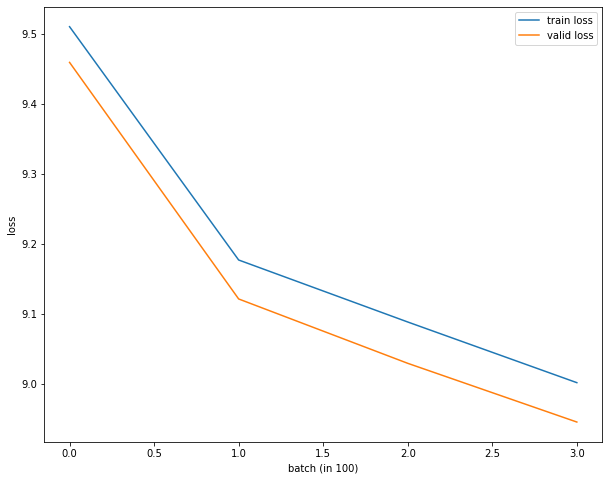

In [74]:
q5_mlp = MyMLP(
    X_subtrain=X_subtrain,
    Y_subtrain=Y_subtrain,
    X_valid=X_valid,
    Y_valid=Y_valid,
    H=90,
    lr=0.001,
    wd=0,
    mom=0,
    loss_type=0,
    optimizer_type=1,
    use_dropout=True,
    dropout_rate=0.5
)
train_loss_list, valid_loss_list = q5_mlp.fit(
    max_epoch=100,
    verbose=True,
    patience_batch_num=5000,
    model_path='q5_mlp.ckpt'
)

# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
draw_loss(train_loss_list, valid_loss_list)

TODO: 補上面 train, test RMSE 的圖與討論

#### Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

In [75]:
q6_h_list = [20, 45, 180, 360]
test_rmse_list = []
for h in q6_h_list:
    print(f"Start training for h = {h}")
    mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=0,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5
    )
    mlp.fit(
        max_epoch=100,
        verbose=True,
        patience_batch_num=5000,
        model_path=f'q6_mlp_h_{h}.ckpt'
    )
    best_model = torch.load(f'q6_mlp_h_{h}.ckpt')
    test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
    test_rmse_list.append(test_rmse_loss)
    print(f"Test RMSE Loss for h = {h}: {test_rmse_loss}")

Start training for h = 20
Epoch: 0, Step: 100, Train Loss: 9.484375924691175, Valid Loss: 9.429079711561469
Epoch: 0, Step: 200, Train Loss: 9.155605453209207, Valid Loss: 9.09415657672566
Epoch: 0, Step: 300, Train Loss: 9.078109546708385, Valid Loss: 9.018124275033228
Epoch: 0, Step: 400, Train Loss: 8.998479935410609, Valid Loss: 8.937228508075073
Test RMSE Loss for h = 20: 9.035854605526144
Start training for h = 45
Epoch: 0, Step: 100, Train Loss: 9.514501564757039, Valid Loss: 9.472043268416481
Epoch: 0, Step: 200, Train Loss: 9.149582268263702, Valid Loss: 9.089289996173514
Epoch: 0, Step: 300, Train Loss: 9.03695488443466, Valid Loss: 8.971138808789759
Epoch: 0, Step: 400, Train Loss: 9.00693640778153, Valid Loss: 8.950389844098476
Test RMSE Loss for h = 45: 9.039665902622092
Start training for h = 180
Epoch: 0, Step: 100, Train Loss: 9.492107819317397, Valid Loss: 9.449523158096376
Epoch: 0, Step: 200, Train Loss: 9.166615586832224, Valid Loss: 9.11094016129262
Epoch: 0, Step:

In [76]:
# print rmse according to different h
for h, rmse in zip(q6_h_list, test_rmse_list):
    print(f"Test RMSE Loss for h = {h}: {rmse}")

Test RMSE Loss for h = 20: 9.035854605526144
Test RMSE Loss for h = 45: 9.039665902622092
Test RMSE Loss for h = 180: 9.07097727927287
Test RMSE Loss for h = 360: 9.074801229729141


TODO: 討論上面不同 H 的 Test RMSE


#### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


Epoch: 0, Step: 100, Train Loss: 9.485596531204655, Valid Loss: 9.44304035182519
Epoch: 0, Step: 200, Train Loss: 9.146570909863813, Valid Loss: 9.085387834149921
Epoch: 0, Step: 300, Train Loss: 9.084291114232704, Valid Loss: 9.031876559558357
Epoch: 0, Step: 400, Train Loss: 8.993031464142478, Valid Loss: 8.936372371804653


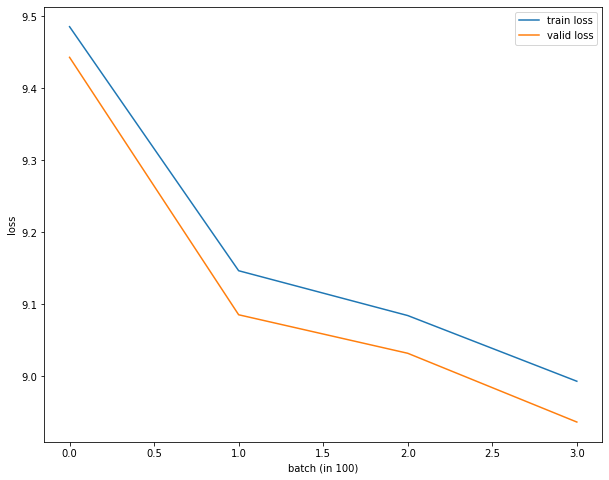

In [79]:
q7_mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=1,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=0.5
    )
train_loss_list, valid_loss_list = q7_mlp.fit(
    max_epoch=100,
    verbose=True,
    patience_batch_num=5000,
    model_path='q7_mlp.ckpt'
)

# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
draw_loss(train_loss_list, valid_loss_list)

In [77]:
q7_z_list = [0.0, 0.1, 0.9, 1.0]
test_rmse_list = []
for z in q7_z_list:
    print(f"Start training for z = {z}")
    mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=1,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=z
    )
    mlp.fit(
        max_epoch=100,
        verbose=True,
        patience_batch_num=5000,
        model_path=f'q7_mlp_z_{z}.ckpt'
    )
    best_model = torch.load(f'q7_mlp_z_{z}.ckpt')
    test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
    test_rmse_list.append(test_rmse_loss)
    print(f"Test RMSE Loss for z = {z}: {test_rmse_loss}")

Epoch: 0, Step: 100, Train Loss: 10.555643091566708, Valid Loss: 10.528791908975442
Epoch: 0, Step: 200, Train Loss: 9.848395787823549, Valid Loss: 9.81529521444039
Epoch: 0, Step: 300, Train Loss: 9.448803725291176, Valid Loss: 9.409947813949028
Epoch: 0, Step: 400, Train Loss: 9.335413687000898, Valid Loss: 9.289090961072647
Test RMSE Loss for z = 0.0: 9.304864811036
Epoch: 0, Step: 100, Train Loss: 9.67542116094656, Valid Loss: 9.641225013915806
Epoch: 0, Step: 200, Train Loss: 9.19917595691697, Valid Loss: 9.15334477694456
Epoch: 0, Step: 300, Train Loss: 9.05370868579659, Valid Loss: 8.998593144341926
Epoch: 0, Step: 400, Train Loss: 8.99839468234832, Valid Loss: 8.94234118425066
Test RMSE Loss for z = 0.1: 9.031149041109654
Epoch: 0, Step: 100, Train Loss: 9.463102805220398, Valid Loss: 9.418726684518967
Epoch: 0, Step: 200, Train Loss: 9.16453237857522, Valid Loss: 9.109038103660389
Epoch: 0, Step: 300, Train Loss: 9.044659100038773, Valid Loss: 8.978137180392698
Epoch: 0, Step:

In [78]:
# print rmse according to different z
for z, rmse in zip(q7_z_list, test_rmse_list):
    print(f"Test RMSE Loss for z = {z}: {rmse}")

Test RMSE Loss for z = 0.0: 9.304864811036
Test RMSE Loss for z = 0.1: 9.031149041109654
Test RMSE Loss for z = 0.9: 9.028635748680438
Test RMSE Loss for z = 1.0: 9.078422479264411



#### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


Epoch: 0, Step: 100, Train Loss: 10.562972664091713, Valid Loss: 10.534833498357248
Epoch: 0, Step: 200, Train Loss: 9.623035138814426, Valid Loss: 9.588142672012797
Epoch: 0, Step: 300, Train Loss: 9.479755123342352, Valid Loss: 9.441606543451137
Epoch: 0, Step: 400, Train Loss: 9.351502649231898, Valid Loss: 9.308279602406207


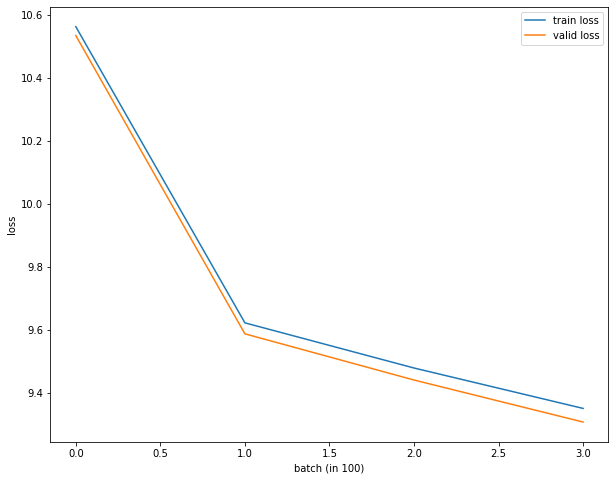

In [83]:
q8_mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=2,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=0
    )
train_loss_list, valid_loss_list = q8_mlp.fit(
    max_epoch=100,
    verbose=True,
    patience_batch_num=5000,
    model_path='q8_mlp.ckpt'
)

# draw the training loss and validation loss
# make figure larger
plt.figure(figsize=(10, 8))
draw_loss(train_loss_list, valid_loss_list)

TODO: 補上面 train, test RMSE 的圖與討論

In [85]:
q8_z_list = [0.1, 0.5, 0.9, 1.0]
test_rmse_list = []
for z in q8_z_list:
    print(f"Start training for z = {z}")
    mlp = MyMLP(
        X_subtrain=X_subtrain,
        Y_subtrain=Y_subtrain,
        X_valid=X_valid,
        Y_valid=Y_valid,
        H=90,
        lr=0.001,
        wd=0,
        mom=0,
        loss_type=2,
        optimizer_type=1,
        use_dropout=True,
        dropout_rate=0.5,
        loss_z=z
    )
    mlp.fit(
        max_epoch=100,
        verbose=True,
        patience_batch_num=5000,
        model_path=f'q8_mlp_z_{z}.ckpt'
    )
    best_model = torch.load(f'q8_mlp_z_{z}.ckpt')
    test_rmse_loss = calculate_test_rmse(best_model, X_test, Y_test)
    test_rmse_list.append(test_rmse_loss)
    print(f"Test RMSE Loss for z = {z}: {test_rmse_loss}")

Start training for z = 0.1
Epoch: 0, Step: 100, Train Loss: 9.838030240735081, Valid Loss: 9.803581214459284
Epoch: 0, Step: 200, Train Loss: 9.24847797302357, Valid Loss: 9.199524404856154
Epoch: 0, Step: 300, Train Loss: 9.065374575363192, Valid Loss: 9.001825743495962
Epoch: 0, Step: 400, Train Loss: 9.0038105668121, Valid Loss: 8.940357813686242
Test RMSE Loss for z = 0.1: 9.036390219815342
Start training for z = 0.5
Epoch: 0, Step: 100, Train Loss: 9.513849302397857, Valid Loss: 9.466625479128684
Epoch: 0, Step: 200, Train Loss: 9.18098816882652, Valid Loss: 9.12264825903717
Epoch: 0, Step: 300, Train Loss: 9.082056453510274, Valid Loss: 9.020201007640116
Epoch: 0, Step: 400, Train Loss: 9.00280948274377, Valid Loss: 8.945507204834517
Test RMSE Loss for z = 0.5: 9.047437504089102
Start training for z = 0.9
Epoch: 0, Step: 100, Train Loss: 9.504086198309748, Valid Loss: 9.460325580183799
Epoch: 0, Step: 200, Train Loss: 9.176466484784047, Valid Loss: 9.122635548346166
Epoch: 0, Ste

In [86]:
# print rmse according to different z
for z, rmse in zip(q8_z_list, test_rmse_list):
    print(f"Test RMSE Loss for z = {z}: {rmse}")

Test RMSE Loss for z = 0.1: 9.036390219815342
Test RMSE Loss for z = 0.5: 9.047437504089102
Test RMSE Loss for z = 0.9: 9.025136051038725
Test RMSE Loss for z = 1.0: 9.036078366715229


TODO: 討論上面不同 z 的 Test RMSE